<a href="https://colab.research.google.com/github/Abhinavanand11/cnn-xgboost/blob/main/cnn_xgboost_comparision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pycbc


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal as scipy_signal
from scipy.interpolate import interp1d
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import xgboost as xgb
from sklearn.metrics import (roc_auc_score, precision_recall_curve, auc, roc_curve,
                             confusion_matrix, accuracy_score, precision_score,
                             recall_score, f1_score)
from sklearn.model_selection import train_test_split
import time
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Set random seeds for reproducibility
def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

In [ ]:

import numpy as np
from pycbc.waveform import get_td_waveform
from pycbc.psd import aLIGOZeroDetHighPower
from pycbc.noise import noise_from_psd
from pycbc.filter import highpass
from pycbc.types import TimeSeries
import scipy.signal as scipy_signal

def generate_gw_signal_pycbc(duration=1.0, fs=2048, m1=30, m2=30, distance=400):
    """

    duration :Signal duration in seconds
    fs : Sampling frequency in Hz
    m1, m2 :  Component masses in solar masses
    distance : Luminosity distance in Mpc


    signal : Time-domain gravitational wave strain
    """
    delta_t = 1.0 / fs

    # Generate waveform using IMRPhenomD approximant (good for BBH mergers)
    hp, hc = get_td_waveform(
        approximant='IMRPhenomD',
        mass1=m1,
        mass2=m2,
        delta_t=delta_t,
        f_lower=20.0,
        distance=distance
    )

    # Use h_plus polarization and resize to desired duration
    n_samples = int(duration * fs)

    if len(hp) < n_samples:
        # Pad with zeros if signal is shorter
        signal = np.zeros(n_samples)
        signal[:len(hp)] = hp.numpy()
    else:
        # Trim if signal is longer
        signal = hp.numpy()[:n_samples]

    return signal


def generate_pycbc_noise(duration=1.0, fs=2048):
    """
    Generate realistic detector noise using PyCBC


    duration : Noise duration in seconds
    fs :Sampling frequency in Hz


    noise : Colored noise array
    """
    delta_t = 1.0 / fs
    n_samples = int(duration * fs)

    # Generate PSD
    delta_f = 1.0 / duration
    flen = n_samples // 2 + 1
    psd = aLIGOZeroDetHighPower(flen, delta_f, 20.0)

    # Generate colored noise from PSD
    noise_ts = noise_from_psd(n_samples, delta_t, psd, seed=None)

    return noise_ts.numpy()


def bandpass_filter(data, lowcut=20, highcut=500, fs=2048, order=4):
    """Apply Butterworth bandpass filter"""
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = scipy_signal.butter(order, [low, high], btype='band')
    filtered = scipy_signal.filtfilt(b, a, data)
    return filtered


def whiten_data_pycbc(data, fs=2048, duration=1.0):
    """
    Whiten data using PSD estimation


    data : Input time series data
    fs : Sampling frequency
    duration : Duration of the data


    whitened :Whitened time series
    """
    delta_t = 1.0 / fs

    # Use scipy's welch method for PSD estimation
    # Adjust segment length based on data duration
    seg_length = min(len(data) // 4, int(0.5 * fs))
    seg_length = max(seg_length, 256)

    freqs, psd_estimate = scipy_signal.welch(
        data,
        fs=fs,
        nperseg=seg_length,
        noverlap=seg_length // 2
    )

    # Whiten in frequency domain
    data_fft = np.fft.rfft(data)
    freqs_fft = np.fft.rfftfreq(len(data), delta_t)

    # Interpolate PSD to match FFT frequencies
    psd_interp = np.interp(freqs_fft, freqs, psd_estimate)
    psd_interp = np.maximum(psd_interp, np.median(psd_estimate) * 0.01)

    # Apply whitening
    whitened_fft = data_fft / np.sqrt(psd_interp * fs / 2)
    whitened_fft[0] = 0

    whitened = np.fft.irfft(whitened_fft, len(data))

    return whitened


def normalize_data(data):
    """Normalize to zero mean and unit variance"""
    return (data - np.mean(data)) / (np.std(data) + 1e-8)


def preprocess_gw_data(data, fs=2048):
    """Complete preprocessing pipeline"""
    filtered = bandpass_filter(data, lowcut=20, highcut=500, fs=fs)
    whitened = whiten_data_pycbc(filtered, fs=fs)
    normalized = normalize_data(whitened)
    return normalized


def generate_dataset_pycbc(n_samples=5000, duration=1.0, fs=2048, snr_range=(5, 20)):
    """
    Generate dataset with signals + noise and pure noise using PyCBC


    n_samples : Number of samples per class (total will be 2*n_samples)
    duration :Duration of each sample in seconds
    fs :  Sampling frequency in Hz
    snr_range :Range of SNR values for signal injection


    X : Array of shape (2*n_samples, n_timesteps)
    y :  Labels (0 for noise, 1 for signal+noise)
    """
    n_timesteps = int(duration * fs)
    X = np.zeros((2 * n_samples, n_timesteps))
    y = np.zeros(2 * n_samples)

    print("Generating dataset with PyCBC...")

    for i in range(2 * n_samples):
        # Generate noise
        noise = generate_pycbc_noise(duration, fs)

        if i < n_samples:
            # Pure noise samples
            X[i] = noise
            y[i] = 0
        else:
            # Signal + noise samples
            m1 = np.random.uniform(20, 50)
            m2 = np.random.uniform(20, 50)
            distance = np.random.uniform(200, 800)

            # Generate signal
            signal = generate_gw_signal_pycbc(duration, fs, m1, m2, distance)

            # Random time shift
            shift = np.random.randint(0, n_timesteps // 4)
            signal = np.roll(signal, shift)

            # Scale signal to target SNR
            target_snr = np.random.uniform(*snr_range)
            signal_power = np.sum(signal**2)
            noise_power = np.sum(noise**2)
            current_snr = np.sqrt(signal_power / noise_power)

            if current_snr > 0:
                scaling = target_snr / current_snr
                signal = signal * scaling

            X[i] = signal + noise
            y[i] = 1

        if (i + 1) % 500 == 0:
            print(f"  Generated {i + 1}/{2 * n_samples} samples")

    print("Preprocessing all samples...")
    for i in range(2 * n_samples):
        X[i] = preprocess_gw_data(X[i], fs)
        if (i + 1) % 500 == 0:
            print(f"  Preprocessed {i + 1}/{2 * n_samples} samples")

    return X, y


def save_dataset(X, y, filename='gw_dataset.npz'):

    np.savez_compressed(filename, X=X, y=y)
    print(f"Dataset saved to {filename}")
    print(f"  Shape: X={X.shape}, y={y.shape}")



def load_dataset(filename='gw_dataset.npz'):

    data = np.load(filename)
    X = data['X']
    y = data['y']
    print(f"Dataset loaded from {filename}")
    print(f"  Shape: X={X.shape}, y={y.shape}")
    return X, y

In [ ]:
class GWDataset(Dataset):
    """PyTorch Dataset for GW data"""
    def __init__(self, X, y):
        self.X = torch.FloatTensor(X)
        self.y = torch.FloatTensor(y)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [ ]:
class CNN_Model(nn.Module):
    """Pure CNN model for end-to-end classification"""
    def __init__(self, input_length=2048, n_filters=[32, 64, 96], dropout=0.4):
        super(CNN_Model, self).__init__()

        layers = []
        in_channels = 1

        for n_filt in n_filters:
            layers.extend([
                nn.Conv1d(in_channels, n_filt, kernel_size=16, padding=8),
                nn.BatchNorm1d(n_filt),
                nn.ReLU(),
                nn.MaxPool1d(2),
                nn.Dropout(dropout)
            ])
            in_channels = n_filt

        self.conv_layers = nn.Sequential(*layers)
        self.global_pool = nn.AdaptiveAvgPool1d(1)

        self.fc = nn.Sequential(
            nn.Linear(n_filters[-1], 64),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(64, 1),

        )

    def forward(self, x):
        x = x.unsqueeze(1)
        x = self.conv_layers(x)
        x = self.global_pool(x)
        x = x.squeeze(-1)
        x = self.fc(x)
        return x.squeeze()

In [ ]:
class RNN_Model(nn.Module):
    """Unidirectional RNN model"""
    def __init__(self, input_size=1, hidden_size=160, num_layers=3, dropout=0.4):
        super(RNN_Model, self).__init__()

        self.rnn = nn.RNN(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0,
            nonlinearity='tanh'  # or 'relu'
        )

        self.fc = nn.Sequential(
            nn.Linear(hidden_size, 64),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(64, 1),

        )

    def forward(self, x):
        x = x.unsqueeze(-1)
        rnn_out, _ = self.rnn(x)
        last_hidden = rnn_out[:, -1, :]
        x = self.fc(last_hidden)
        return x.squeeze()

In [ ]:
class CNN_FeatureExtractor(nn.Module):
    """CNN feature extractor for hybrid model"""
    def __init__(self, input_length=2048, n_filters=[32, 64, 96],
                 embedding_dim=64, dropout=0.4):
        super(CNN_FeatureExtractor, self).__init__()

        layers = []
        in_channels = 1

        for n_filt in n_filters:
            layers.extend([
                nn.Conv1d(in_channels, n_filt, kernel_size=16, padding=8),
                nn.BatchNorm1d(n_filt),
                nn.ReLU(),
                nn.MaxPool1d(2),
                nn.Dropout(dropout)
            ])
            in_channels = n_filt

        self.conv_layers = nn.Sequential(*layers)
        self.global_pool = nn.AdaptiveAvgPool1d(1)

        self.embedding = nn.Sequential(
            nn.Linear(n_filters[-1], embedding_dim),
            nn.ReLU(),
            nn.Dropout(dropout)
        )

        self.embedding_dim = embedding_dim

    def forward(self, x):
        x = x.unsqueeze(1)
        x = self.conv_layers(x)
        x = self.global_pool(x)
        x = x.squeeze(-1)
        embeddings = self.embedding(x)
        return embeddings


In [ ]:
def count_parameters(model):
    """Count trainable parameters"""
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


In [ ]:
def train_neural_network(model, train_loader, val_loader, epochs=50,
                        lr=0.001, device='cpu', model_name='Model'):
    """Train CNN or RNN model"""
    print(f"\nTraining {model_name}...")
    start_time = time.time()

    model = model.to(device)


    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', patience=5, factor=0.5
    )

    best_val_loss = float('inf')
    patience = 15
    patience_counter = 0

    for epoch in range(epochs):
        model.train()
        train_loss = 0

        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        train_loss /= len(train_loader)

        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)
                val_loss += loss.item()

        val_loss /= len(val_loader)
        scheduler.step(val_loss)

        if (epoch + 1) % 10 == 0:
            print(f"  Epoch {epoch+1}/{epochs} - Train: {train_loss:.4f}, Val: {val_loss:.4f}")

        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            best_model_state = model.state_dict()
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"  Early stopping at epoch {epoch+1}")
                break

    model.load_state_dict(best_model_state)
    training_time = time.time() - start_time

    print(f"  Training completed in {training_time:.2f} seconds")

    return model, training_time

In [ ]:
def train_cnn_xgboost_hybrid(train_loader, val_loader, device='cpu'):
    """Train CNN-XGBoost hybrid model"""
    print("\nTraining CNN-XGBoost Hybrid...")
    start_time = time.time()

    # Stage 1: Train CNN feature extractor
    print("  Stage 1: Pre-training CNN feature extractor...")
    cnn = CNN_FeatureExtractor(embedding_dim=64, dropout=0.4).to(device)

    # Auxiliary classifier for pre-training
    aux_classifier = nn.Sequential(
        nn.Linear(64, 32),
        nn.ReLU(),
        nn.Dropout(0.3),
        nn.Linear(32, 1),
        nn.Sigmoid()
    ).to(device)

    params = list(cnn.parameters()) + list(aux_classifier.parameters())
    optimizer = optim.Adam(params, lr=0.001, weight_decay=1e-4)
    criterion = nn.BCELoss()
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', patience=5, factor=0.5
    )

    best_val_loss = float('inf')
    patience_counter = 0

    for epoch in range(30):
        cnn.train()
        aux_classifier.train()

        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            embeddings = cnn(X_batch)
            outputs = aux_classifier(embeddings).squeeze()
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()

        # Validation
        cnn.eval()
        aux_classifier.eval()
        val_loss = 0

        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                embeddings = cnn(X_batch)
                outputs = aux_classifier(embeddings).squeeze()
                loss = criterion(outputs, y_batch)
                val_loss += loss.item()

        val_loss /= len(val_loader)
        scheduler.step(val_loss)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            best_cnn_state = cnn.state_dict()
        else:
            patience_counter += 1
            if patience_counter >= 10:
                break

    cnn.load_state_dict(best_cnn_state)

    # Stage 2: Extract embeddings and train XGBoost
    print("  Stage 2: Training XGBoost on CNN embeddings...")
    cnn.eval()

    # Extract embeddings
    train_embeddings, train_labels = [], []
    with torch.no_grad():
        for X_batch, y_batch in train_loader:
            X_batch = X_batch.to(device)
            embeddings = cnn(X_batch)
            train_embeddings.append(embeddings.cpu().numpy())
            train_labels.append(y_batch.numpy())

    train_embeddings = np.vstack(train_embeddings)
    train_labels = np.concatenate(train_labels)

    val_embeddings, val_labels = [], []
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch = X_batch.to(device)
            embeddings = cnn(X_batch)
            val_embeddings.append(embeddings.cpu().numpy())
            val_labels.append(y_batch.numpy())

    val_embeddings = np.vstack(val_embeddings)
    val_labels = np.concatenate(val_labels)

    # Train XGBoost
    xgb_model = xgb.XGBClassifier(
        objective='binary:logistic',
        max_depth=6,
        learning_rate=0.1,
        n_estimators=200,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        tree_method='hist',
        early_stopping_rounds=20
    )

    xgb_model.fit(
        train_embeddings,
        train_labels,
        eval_set=[(val_embeddings, val_labels)],
        verbose=False
    )

    training_time = time.time() - start_time

    # Calculate total parameters (CNN only, XGBoost doesn't have "parameters" in same sense)
    total_params = count_parameters(cnn)

    print(f"  Training completed in {training_time:.2f} seconds")

    return cnn, xgb_model, training_time, total_params

In [ ]:

def evaluate_neural_network(model, test_loader, device='cpu'):
    """Evaluate CNN or RNN model"""
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch = X_batch.to(device)
            outputs = model(X_batch)
            all_preds.extend(outputs.cpu().numpy())
            all_labels.extend(y_batch.numpy())

    return np.array(all_preds), np.array(all_labels)

def evaluate_hybrid(cnn, xgb_model, test_loader, device='cpu'):
    """Evaluate CNN-XGBoost hybrid"""
    cnn.eval()

    # Extract embeddings
    test_embeddings, test_labels = [], []
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch = X_batch.to(device)
            embeddings = cnn(X_batch)
            test_embeddings.append(embeddings.cpu().numpy())
            test_labels.append(y_batch.numpy())

    test_embeddings = np.vstack(test_embeddings)
    test_labels = np.concatenate(test_labels)

    # Predict with XGBoost
    predictions = xgb_model.predict_proba(test_embeddings)[:, 1]

    return predictions, test_labels

def calculate_metrics(predictions, labels, threshold=0.5):
    """Calculate all metrics"""
    # Binary predictions
    binary_preds = (predictions >= threshold).astype(int)

    # Calculate metrics
    accuracy = accuracy_score(labels, binary_preds)
    precision = precision_score(labels, binary_preds, zero_division=0)
    recall = recall_score(labels, binary_preds, zero_division=0)
    f1 = f1_score(labels, binary_preds, zero_division=0)

    # Confusion matrix
    cm = confusion_matrix(labels, binary_preds)

    # ROC-AUC
    roc_auc = roc_auc_score(labels, predictions)

    # PR-AUC
    prec, rec, _ = precision_recall_curve(labels, predictions)
    pr_auc = auc(rec, prec)

    # Sensitivity at 1% FAR
    fpr, tpr, _ = roc_curve(labels, predictions)
    idx = np.where(fpr <= 0.01)[0]
    if len(idx) > 0:
        sensitivity_at_1pct_far = tpr[idx[-1]]
    else:
        sensitivity_at_1pct_far = 0.0

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'confusion_matrix': cm,
        'roc_auc': roc_auc,
        'pr_auc': pr_auc,
        'sensitivity_at_1pct_far': sensitivity_at_1pct_far
    }

In [ ]:
def plot_confusion_matrices(results, save_path=None):
    """Plot confusion matrices for all models"""
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))

    models = ['CNN', 'RNN', 'CNN-XGBoost']

    for idx, (model_name, ax) in enumerate(zip(models, axes)):
        cm = results[model_name.lower().replace('-', '_')]['confusion_matrix']

        im = ax.imshow(cm, cmap='Blues', aspect='auto')
        ax.set_xticks([0, 1])
        ax.set_yticks([0, 1])
        ax.set_xticklabels(['Noise', 'Signal'])
        ax.set_yticklabels(['Noise', 'Signal'])
        ax.set_xlabel('Predicted')
        ax.set_ylabel('True')
        ax.set_title(f'{model_name} Confusion Matrix')

        # Add text annotations
        for i in range(2):
            for j in range(2):
                text = ax.text(j, i, cm[i, j],
                             ha="center", va="center", color="black", fontsize=14)

        plt.colorbar(im, ax=ax)

    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
    plt.show()


In [ ]:
def plot_roc_curves(results, predictions_dict, labels_dict, save_path=None):
    """Plot ROC curves for all models"""
    plt.figure(figsize=(10, 8))

    models = ['CNN', 'RNN', 'CNN-XGBoost']
    colors = ['#2E86AB', '#A23B72', '#F18F01']  # Blue, Purple, Orange
    linestyles = ['-', '--', '-.']

    for model_name, color, linestyle in zip(models, colors, linestyles):
        key = model_name.lower().replace('-', '_')
        fpr, tpr, thresholds = roc_curve(labels_dict[key], predictions_dict[key])
        auc_score = results[key]['roc_auc']

        plt.plot(fpr, tpr, color=color, lw=2.5, linestyle=linestyle,
                label=f'{model_name} (AUC = {auc_score:.4f})')

    # Add diagonal reference line
    plt.plot([0, 1], [0, 1], 'k--', lw=1.5, alpha=0.5, label='Random Classifier (AUC = 0.5)')

    # Styling
    plt.xlim([-0.02, 1.02])
    plt.ylim([-0.02, 1.05])
    plt.xlabel('False Positive Rate (FPR)', fontsize=13, fontweight='bold')
    plt.ylabel('True Positive Rate (TPR) / Sensitivity', fontsize=13, fontweight='bold')
    plt.title('ROC Curves Comparison - Gravitational Wave Detection',
              fontsize=15, fontweight='bold', pad=15)
    plt.legend(loc="lower right", fontsize=11, framealpha=0.95)
    plt.grid(True, alpha=0.3, linestyle='--')

    # Add text annotation
    plt.text(0.6, 0.2, 'Better models\nhug top-left corner',
             fontsize=10, style='italic', alpha=0.7,
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.3))

    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

In [ ]:
def plot_pr_curves(results, predictions_dict, labels_dict, save_path=None):
    """Plot Precision-Recall curves for all models"""
    plt.figure(figsize=(10, 8))

    models = ['CNN', 'RNN', 'CNN-XGBoost']
    colors = ['#2E86AB', '#A23B72', '#F18F01']  # Blue, Purple, Orange
    linestyles = ['-', '--', '-.']

    # Calculate baseline (random classifier for imbalanced data)
    # Baseline precision = fraction of positive class
    for key in labels_dict:
        baseline_precision = np.mean(labels_dict[key])
        break

    for model_name, color, linestyle in zip(models, colors, linestyles):
        key = model_name.lower().replace('-', '_')
        precision, recall, thresholds = precision_recall_curve(
            labels_dict[key], predictions_dict[key]
        )
        pr_auc_score = results[key]['pr_auc']

        plt.plot(recall, precision, color=color, lw=2.5, linestyle=linestyle,
                label=f'{model_name} (AUC = {pr_auc_score:.4f})')

    # Add baseline reference line
    plt.plot([0, 1], [baseline_precision, baseline_precision],
             'k--', lw=1.5, alpha=0.5,
             label=f'Random Classifier (AUC = {baseline_precision:.4f})')

    # Styling
    plt.xlim([-0.02, 1.02])
    plt.ylim([-0.02, 1.05])
    plt.xlabel('Recall (Sensitivity)', fontsize=13, fontweight='bold')
    plt.ylabel('Precision', fontsize=13, fontweight='bold')
    plt.title('Precision-Recall Curves Comparison - Gravitational Wave Detection',
              fontsize=15, fontweight='bold', pad=15)
    plt.legend(loc="lower left", fontsize=11, framealpha=0.95)
    plt.grid(True, alpha=0.3, linestyle='--')

    # Add text annotation
    plt.text(0.4, 0.95, 'Better models\nhug top-right corner',
             fontsize=10, style='italic', alpha=0.7,
             bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.3))

    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

In [ ]:
device='cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
def set_seed(seed=42):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)

# Generate and save
n_samples = 20000
device = 'cuda' if torch.cuda.is_available() else 'cpu'
set_seed(42)

X, y = generate_dataset_pycbc(n_samples=n_samples, duration=1.0, fs=2048, snr_range=(5, 20))
save_dataset(X, y, filename='gw_dataset_2000samples.npz')

# Load later
X, y = load_dataset('gw_dataset_2000samples.npz')

Generating dataset with PyCBC...
  Generated 500/40000 samples
  Generated 1000/40000 samples
  Generated 1500/40000 samples
  Generated 2000/40000 samples
  Generated 2500/40000 samples
  Generated 3000/40000 samples
  Generated 3500/40000 samples
  Generated 4000/40000 samples
  Generated 4500/40000 samples
  Generated 5000/40000 samples
  Generated 5500/40000 samples
  Generated 6000/40000 samples
  Generated 6500/40000 samples
  Generated 7000/40000 samples
  Generated 7500/40000 samples
  Generated 8000/40000 samples
  Generated 8500/40000 samples
  Generated 9000/40000 samples
  Generated 9500/40000 samples
  Generated 10000/40000 samples
  Generated 10500/40000 samples
  Generated 11000/40000 samples
  Generated 11500/40000 samples
  Generated 12000/40000 samples
  Generated 12500/40000 samples
  Generated 13000/40000 samples
  Generated 13500/40000 samples
  Generated 14000/40000 samples
  Generated 14500/40000 samples
  Generated 15000/40000 samples
  Generated 15500/40000 sam

In [ ]:
# Split data
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.4, random_state=42, stratify=y
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

print(f"\nDataset splits:")
print(f"  Train: {len(X_train)} samples")
print(f"  Val: {len(X_val)} samples")
print(f"  Test: {len(X_test)} samples")


Dataset splits:
  Train: 24000 samples
  Val: 8000 samples
  Test: 8000 samples


In [ ]:
batch_size = 32
train_dataset = GWDataset(X_train, y_train)
val_dataset = GWDataset(X_val, y_val)
test_dataset = GWDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [ ]:
results = {}
predictions_dict = {}
labels_dict = {}

In [ ]:
print("MODEL 1: CNN")
print("-"*80)
cnn_model = CNN_Model(input_length=X.shape[1])
print(f"Parameters: {count_parameters(cnn_model):,}")

cnn_model, cnn_time = train_neural_network(
    cnn_model, train_loader, val_loader, epochs=50, device=device, model_name='CNN'
)


MODEL 1: CNN
--------------------------------------------------------------------------------
Parameters: 138,433

Training CNN...
  Epoch 10/50 - Train: 0.0240, Val: 0.0109
  Epoch 20/50 - Train: 0.0160, Val: 0.0095
  Epoch 30/50 - Train: 0.0113, Val: 0.0045
  Epoch 40/50 - Train: 0.0091, Val: 0.0037
  Epoch 50/50 - Train: 0.0058, Val: 0.0037
  Training completed in 417.32 seconds


In [ ]:
cnn_preds, cnn_labels = evaluate_neural_network(cnn_model, test_loader, device)
cnn_metrics = calculate_metrics(cnn_preds, cnn_labels)
cnn_metrics['training_time'] = cnn_time
cnn_metrics['parameters'] = count_parameters(cnn_model)

results['cnn'] = cnn_metrics
predictions_dict['cnn'] = cnn_preds
labels_dict['cnn'] = cnn_labels

In [ ]:
print("MODEL 2: RNN")
print("-"*80)
rnn_model = RNN_Model(hidden_size=160, num_layers=3)
print(f"Parameters: {count_parameters(rnn_model):,}")

rnn_model, rnn_time = train_neural_network(
    rnn_model, train_loader, val_loader, epochs=50, device='cuda', model_name='RNN'
)

MODEL 2: RNN
--------------------------------------------------------------------------------
Parameters: 139,489

Training RNN...
  Epoch 10/50 - Train: 0.2434, Val: 0.2021
  Epoch 20/50 - Train: 0.1469, Val: 0.1290
  Epoch 30/50 - Train: 0.1295, Val: 0.1356
  Epoch 40/50 - Train: 0.4310, Val: 0.4282
  Early stopping at epoch 44
  Training completed in 1079.49 seconds


In [ ]:
rnn_preds, rnn_labels = evaluate_neural_network(rnn_model, test_loader, device)
rnn_metrics = calculate_metrics(rnn_preds, rnn_labels)
rnn_metrics['training_time'] = rnn_time
rnn_metrics['parameters'] = count_parameters(rnn_model)

results['rnn'] = rnn_metrics
predictions_dict['rnn'] = rnn_preds
labels_dict['rnn'] = rnn_labels

In [ ]:
print("MODEL 3: CNN-XGBoost Hybrid")
print("-"*80)

cnn_extractor, xgb_model, hybrid_time, hybrid_params = train_cnn_xgboost_hybrid(
    train_loader, val_loader, device
)
print(f"Parameters (CNN only): {hybrid_params:,}")
print(f"XGBoost trees: {xgb_model.n_estimators}")

hybrid_preds, hybrid_labels = evaluate_hybrid(
    cnn_extractor, xgb_model, test_loader, device
)

MODEL 3: CNN-XGBoost Hybrid
--------------------------------------------------------------------------------

Training CNN-XGBoost Hybrid...
  Stage 1: Pre-training CNN feature extractor...
  Stage 2: Training XGBoost on CNN embeddings...
  Training completed in 242.96 seconds
Parameters (CNN only): 138,368
XGBoost trees: 200


In [ ]:
hybrid_metrics = calculate_metrics(hybrid_preds, hybrid_labels)
hybrid_metrics['training_time'] = hybrid_time
hybrid_metrics['parameters'] = hybrid_params

results['cnn_xgboost'] = hybrid_metrics
predictions_dict['cnn_xgboost'] = hybrid_preds
labels_dict['cnn_xgboost'] = hybrid_labels

In [ ]:
print("METRICS COMPARISON TABLE")
print("-"*80)

print(f"\n{'Metric':<25} {'CNN':>15} {'RNN':>15} {'CNN-XGBoost':>15}")
print("-" * 72)

metrics_to_display = [
  ('Accuracy', 'accuracy'),
  ('Precision', 'precision'),
  ('Recall', 'recall'),
  ('F1-Score', 'f1_score'),
  ('ROC-AUC', 'roc_auc'),
  ('PR-AUC', 'pr_auc'),
  ('Sensitivity@1%FAR', 'sensitivity_at_1pct_far'),
  ('Training Time (s)', 'training_time'),
  ('Parameters', 'parameters')
]

for display_name, metric_key in metrics_to_display:
  cnn_val = results['cnn'][metric_key]
  rnn_val = results['rnn'][metric_key]
  hybrid_val = results['cnn_xgboost'][metric_key]

  if metric_key in ['training_time', 'parameters']:
      if metric_key == 'parameters':
          print(f"{display_name:<25} {cnn_val:>15,} {rnn_val:>15,} {hybrid_val:>15,}")
      else:
          print(f"{display_name:<25} {cnn_val:>15.2f} {rnn_val:>15.2f} {hybrid_val:>15.2f}")
  else:
      print(f"{display_name:<25} {cnn_val:>15.4f} {rnn_val:>15.4f} {hybrid_val:>15.4f}")


METRICS COMPARISON TABLE
--------------------------------------------------------------------------------

Metric                                CNN             RNN     CNN-XGBoost
------------------------------------------------------------------------
Accuracy                           0.9995          0.7481          0.9988
Precision                          0.9997          0.8270          0.9990
Recall                             0.9992          0.6275          0.9985
F1-Score                           0.9995          0.7136          0.9987
ROC-AUC                            1.0000          0.8522          1.0000
PR-AUC                             1.0000          0.8542          1.0000
Sensitivity@1%FAR                  1.0000          0.2412          0.9998
Training Time (s)                  417.32         1079.49          242.96
Parameters                        138,433         139,489         138,368



--------------------------------------------------------------------------------
CONFUSION MATRICES
--------------------------------------------------------------------------------

CNN:
  TN: 3999   FP: 1     
  FN: 3      TP: 3997  

RNN:
  TN: 3475   FP: 525   
  FN: 1490   TP: 2510  

CNN-XGBoost:
  TN: 3996   FP: 4     
  FN: 6      TP: 3994  

--------------------------------------------------------------------------------
BEST MODEL FOR EACH METRIC
--------------------------------------------------------------------------------
  Accuracy                 : CNN             (0.9995)
  Precision                : CNN             (0.9997)
  Recall                   : CNN             (0.9992)
  F1-Score                 : CNN             (0.9995)
  ROC-AUC                  : CNN             (1.0000)
  PR-AUC                   : CNN             (1.0000)
  Sensitivity@1%FAR        : CNN             (1.0000)


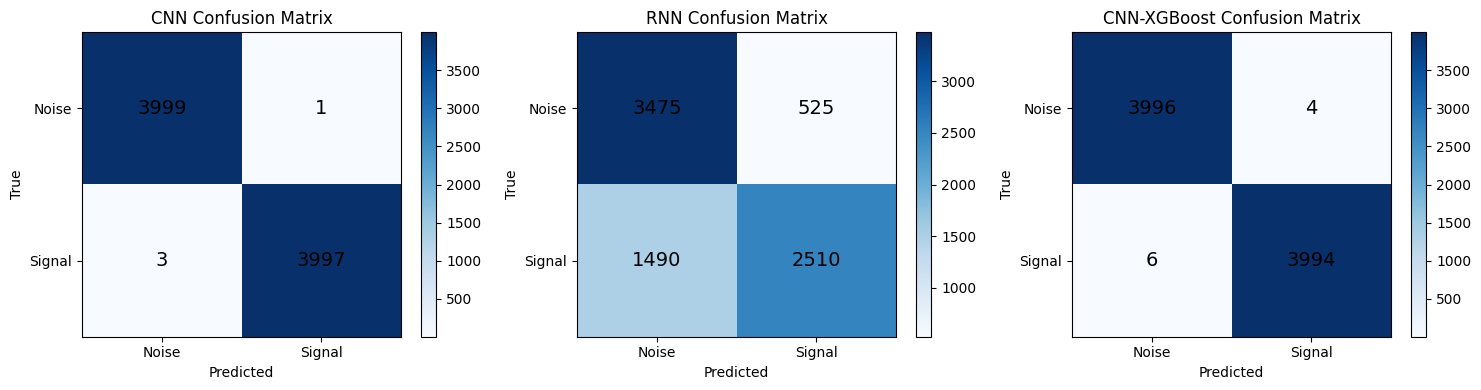

In [ ]:
print("\n" + "-"*80)
print("CONFUSION MATRICES")
print("-"*80)

for model_name, key in [('CNN', 'cnn'), ('RNN', 'rnn'),
                        ('CNN-XGBoost', 'cnn_xgboost')]:
    cm = results[key]['confusion_matrix']
    print(f"\n{model_name}:")
    print(f"  TN: {cm[0,0]:<6} FP: {cm[0,1]:<6}")
    print(f"  FN: {cm[1,0]:<6} TP: {cm[1,1]:<6}")

# Find best model for each metric
print("\n" + "-"*80)
print("BEST MODEL FOR EACH METRIC")
print("-"*80)

model_names = {'cnn': 'CNN', 'rnn': 'RNN', 'cnn_xgboost': 'CNN-XGBoost'}

for display_name, metric_key in metrics_to_display[:7]:  # Exclude time and params
    values = {k: results[k][metric_key] for k in ['cnn', 'rnn', 'cnn_xgboost']}
    best_key = max(values, key=values.get)
    best_name = model_names[best_key]
    best_val = values[best_key]
    print(f"  {display_name:<25}: {best_name:<15} ({best_val:.4f})")
plot_confusion_matrices(results)

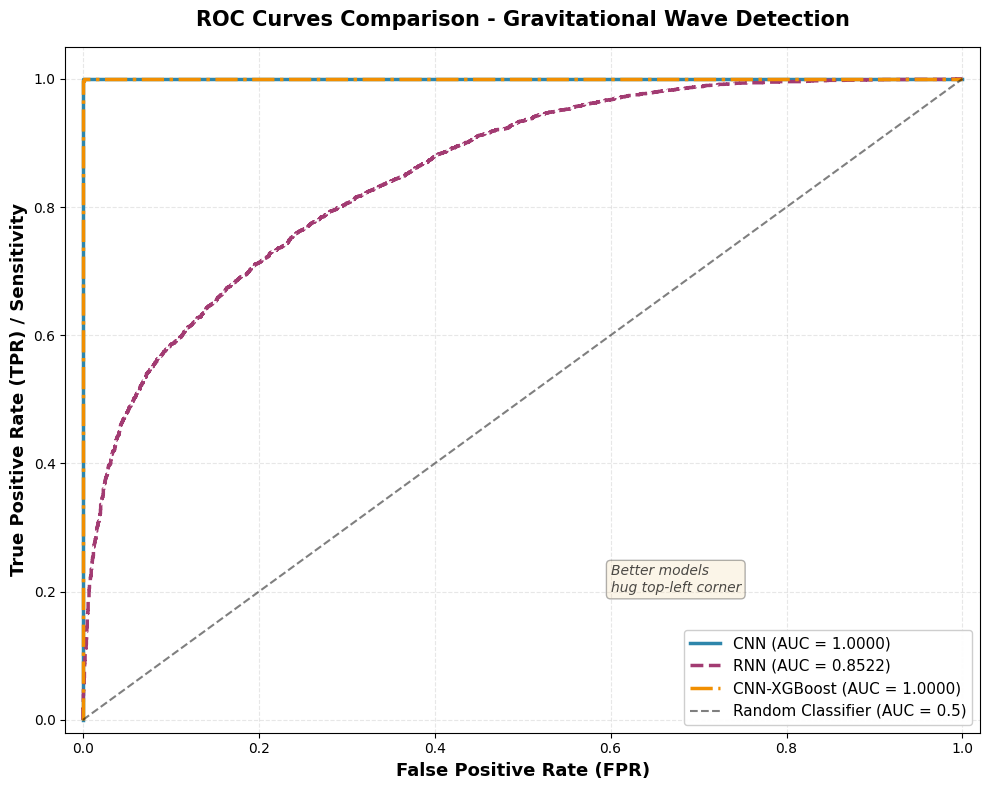

In [ ]:
plot_roc_curves(results, predictions_dict, labels_dict, save_path='roc-auc-20000')

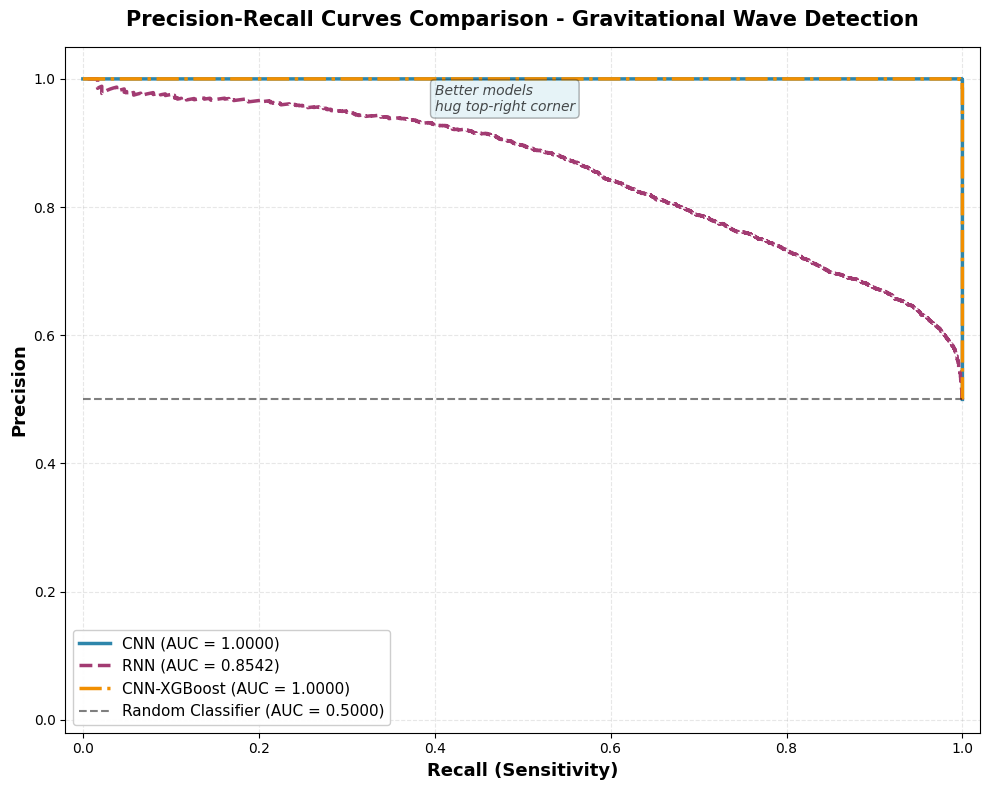

In [ ]:
plot_pr_curves(results, predictions_dict, labels_dict, save_path='pr-auc-20000')

In [ ]:
hybrid = CNN_XGBoost_Hybrid(embedding_dim=256, device=device)